# 1. Install dependencies

In [186]:
%pip install --upgrade pip
%pip install --upgrade langchain-ollama
%pip install --upgrade langgraph

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 2. Initialize the model

In [187]:
from langchain_ollama import ChatOllama

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [188]:
model = ChatOllama(model="llama3-groq-tool-use", temperature=0)
#model = ChatOllama(model="llama3.1", temperature=0)

In [189]:
# Create the primary assistant prompt template
from langchain_core.prompts import ChatPromptTemplate
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with answering user questions. "
            "You have access to two tools: retrieve_documents and web_search. "
            "For any user questions about LLM agents, use the retrieve_documents tool to get information for a vectorstore. "
            "For any other questions, such as questions about current events, use the web_search tool to get information from the web. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# 3. Initialize the tools

In [190]:
from langgraph.prebuilt import ToolNode

@tool
def search(query: str):
    """Run web search on the question.
    
    Args:
        query (str): The query to search for.

    Returns:
        str: The answer to the question.
    """
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 0 ° and foggy."
    return "It's 90 ° and sunny."


tools = [search]

tool_node = ToolNode(tools)

# 4. Initialize graph with state

In [191]:
from langgraph.graph import END, START, StateGraph, MessagesState

In [192]:
from typing import Annotated, Literal, TypedDict

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if "tool_call" in last_message.content:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# 5. Define graph nodes

## 5.1 CREATE AN ASSISTANT CLASS

In [193]:
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing import Annotated, List
from langchain_core.prompts import ChatPromptTemplate

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]



class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with answering user questions. "
            "You have access to one tool: search ."
            "For any questions, such as questions about current events, use the search tool to get real time information from the web. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | model.bind_tools(tools)

## 5.2 Create the graph

In [194]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", Assistant(assistant_runnable))
workflow.add_node("tools", tool_node)

In [195]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

In [196]:
workflow.add_conditional_edges("agent", should_continue, ["tools", END])

In [197]:
workflow.add_edge("tools", 'agent')

In [198]:
checkpointer = MemorySaver()

# 6. Define entry point and graph edges 

# 7. Compile the graph

In [199]:
app = workflow.compile(checkpointer=checkpointer)

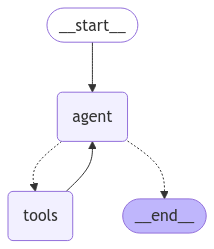

In [200]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [202]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="What is the weather in sf ? Use the search tool to find the weather in sf. ")]},
    config={"configurable": {"thread_id": 45}}
)
final_state["messages"][-1].content# 8. Run Graph


'The current weather in San Francisco (SF) is partly cloudy with a temperature of 68°F (20°C).'

In [161]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="What is the weather in Paris ? Use the search function to find the latest information.")]},
    config={"configurable": {"thread_id": 1}}
)
final_state["messages"][-1].content# 8. Run Graph

'The current weather in Paris is partly cloudy with a temperature of 18°C (64°F).'

In [203]:
final_state["messages"]

[HumanMessage(content='What is the weather in sf ? Use the search tool to find the weather in sf. ', additional_kwargs={}, response_metadata={}, id='645bd9a1-227e-4ab7-91bf-d7d6010407b2'),
 AIMessage(content='<tool_call>\n{"id": 0, "name": "search", "arguments": {"query": "weather in sf"}}\n</tool_call>', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2025-01-09T03:01:36.071319Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1370356792, 'load_duration': 28263959, 'prompt_eval_count': 236, 'prompt_eval_duration': 347187000, 'eval_count': 27, 'eval_duration': 992487000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-5c931add-7583-4f71-8a45-b31e34cfd230-0', usage_metadata={'input_tokens': 236, 'output_tokens': 27, 'total_tokens': 263}),
 AIMessage(content='The current weather in San Francisco (SF) is partly cloudy with a temperature of 68°F (20°C).', additional_kwargs={}, response_metadata={'mode